# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

## Introduction

In this project, a pre-existing image classification model (resnet18) is finetuned to classify different dog breeds. Next to this, hyperparameter optimization is also applied to find the best model. The code that follows below leverages the tools provided by AWS Sagemaker.

In [9]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [10]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

In [11]:
# used to upload data to S3 among other things
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "project-dogbreeds"

role = sagemaker.get_execution_role()

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

**DATA EXPLANATION:** The dataset used within this project consists of 133 different dog breeds. This dataset is already split into training, testing, and validation subsets.

**NOTE:** The two code cells below have been disabled because they slowed down the notebook. Instead they were just run once and the input path was saved to the inputs variable manually.

In [12]:
inputs = "s3://sagemaker-us-east-1-711239616110/project-dogbreeds"

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [13]:
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [7]:
# Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 5) # Limited to 5 to prevent long training times to save on AWS credits
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [8]:
# Setup estimator & HP tuner

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type,
)

In [9]:
# Fit your HP Tuner
tuner.fit({"training": inputs}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [20]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-07-24 17:23:02 Starting - Preparing the instances for training
2022-07-24 17:23:02 Downloading - Downloading input data
2022-07-24 17:23:02 Training - Training image download completed. Training in progress.
2022-07-24 17:23:02 Uploading - Uploading generated training model
2022-07-24 17:23:02 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'epochs': '5',
 'lr': '0.002446411543845345',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-07-24-16-41-04-487"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-711239616110/pytorch-training-2022-07-24-16-41-04-487/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [37]:
# TODO: Set up debugging and profiling rules and hooks

from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    framework_profile_params=FrameworkProfile()
)

"""
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "10"}
)
"""

# Using fix from course forum (https://knowledge.udacity.com/questions/808539)
# Create collection config so that debugger tracks loss value
collection_configs=[
    CollectionConfig(
        name="CrossEntropyLoss_output_0", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", 
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "1", "eval.save_interval": "1"},
    collection_configs=collection_configs
)

In [38]:
# Take HP from best model

hyperparameters = {
    "epochs": 5,
    "batch-size": 128,
    "lr": 0.002446411543845345
}
"""

hyperparameters = {
    "epochs": best_estimator.hyperparameters()["epochs"], 
    "batch-size": int(best_estimator.hyperparameters()["batch-size"].replace('"', '')), 
    "lr": best_estimator.hyperparameters()["lr"]
}"""

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
    framework_version="1.8",
    py_version="py36",
)

In [39]:
# Fit the model with the hooks attached to it
estimator.fit({"training": inputs}, wait=True)

2022-07-25 13:32:32 Starting - Starting the training job...
2022-07-25 13:32:50 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-07-25 13:33:56 Downloading - Downloading input data..............bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-25 13:36:09,890 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-25 13:36:09,893 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-25 13:36:09,902 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-25 13:36:09,908 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-25 13:36:10,376 sagemaker-training-toolki

In [40]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2022-07-25-13-32-32-284
Region: us-east-1


In [41]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-07-25 14:19:05.055 ip-172-16-168-60.ec2.internal:30663 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-07-25 14:19:05.087 ip-172-16-168-60.ec2.internal:30663 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-711239616110/pytorch-training-2022-07-25-13-32-32-284/debug-output
[2022-07-25 14:19:09.315 ip-172-16-168-60.ec2.internal:30663 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-07-25 14:19:10.342 ip-172-16-168-60.ec2.internal:30663 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', '

### Debugging output

In [42]:
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [43]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


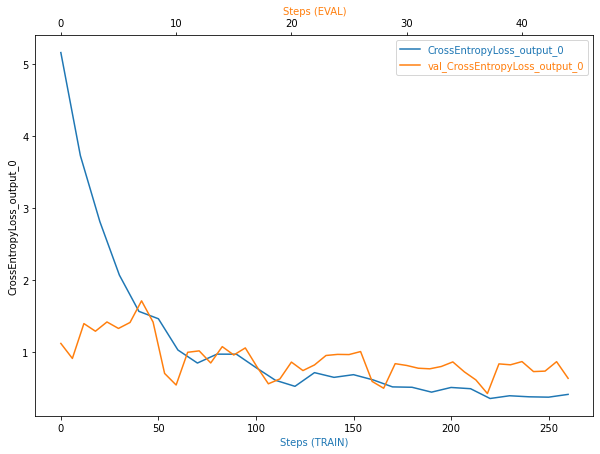

In [45]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

### Profiling output

In [46]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-711239616110/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 7, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 5, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 13, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 9, "NumSteps": 3, "ProfilerName": "cprofile", "cProfileTimer": "default", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 15, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-711239616110/pytorch-training-2022-07-25-13-32-32-284/profiler-output


Profiler data from system is available


In [47]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-07-25 14:20:12.949 ip-172-16-168-60.ec2.internal:30663 INFO metrics_reader_base.py:134] Getting 43 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


### Profiler Report

In [48]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-711239616110/pytorch-training-2022-07-25-13-32-32-284/rule-output


In [49]:
! aws s3 ls {rule_output_path} --recursive

2022-07-25 14:16:36     375523 pytorch-training-2022-07-25-13-32-32-284/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-07-25 14:16:35     223453 pytorch-training-2022-07-25-13-32-32-284/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-07-25 14:16:30        192 pytorch-training-2022-07-25-13-32-32-284/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-07-25 14:16:30        200 pytorch-training-2022-07-25-13-32-32-284/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-07-25 14:16:30       1711 pytorch-training-2022-07-25-13-32-32-284/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-07-25 14:16:30        127 pytorch-training-2022-07-25-13-32-32-284/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-07-25 14:16:30        199 pytorch-training-2022-07-25-13-32-32-284/rule-output/ProfilerReport/profiler-output/profiler-re

In [50]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-711239616110/pytorch-training-2022-07-25-13-32-32-284/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-711239616110/pytorch-training-2022-07-25-13-32-32-284/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-711239616110/pytorch-training-2022-07-25-13-32-32-284/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-711239616110/pytorch-training-2022-07-25-13-32-32-284/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-711239616110/pytorc

In [51]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [52]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint
predictor = estimator.deploy(
    initial_instance_count=1, 
    instance_type="ml.m5.xlarge"
)

In [ ]:
print("Endpoint: {}".format(predictor.endpoint_name))

In [ ]:
# TODO: Run an prediction on the endpoint
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/jpg")
with open("test_114_otterhound", "rb") as f:
    image = f.read()

response = predictor.predict(image)

print(response)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()